# Assignment 4
## Stitching Images (90 Points)


In an iPython notebook stitching.ipynb, import the following

```python
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2 # yes, you can do this, but see below!
```

Go outside the science library onto the grass and take **10 pictures** of the campus, taking care that each picture overlaps with the other, but that you also cover some large area. The pictures need to be submitted with your assignment, of course.

Then implement the full stitching pipeline using a nice set of functions. 
Each function is described below – the input and output parameters should be clear:

`loadImages`: Load images, convert them to double and to grayscale. Return list of images.

`getFeaturePoints`: Detect feature points in an image, using the (Harris) corner
detector you developed in Assignment 3. Save them in a list and return. The function should also plot the detected feature points in the image.

`getFeatureDescriptors`: For a given input list of feature points, extract its
neighborhood using the pixel values in a small window around each point as a feature vector. The window size needs to be a parameter of the function. Return the feature vectors as another list.

`match2Images`: Given lists of feature points and feature descriptors from two
images, match them. For this, compute distances between every descriptor in one
image and every descriptor in the other image – Euclidean distance may work, but
more robust matching can be done with normalized cross correlation (look it up, it’s easy!) of the descriptors. Implement both ways and check later which gives better results. Select matches based on the ratio criterion with a suitable threshold (this is a function parameter). The function should also plot the matches between the two images. Return the matches as a list of indices in the two images.

`refineMatches`: Given lists of feature points and the match list, implement
RANSAC to estimate a homography mapping one image onto the other (so, the full
number of 8 parameters). In each iteration of RANSAC, simply select 4 points at
random, estimate the homography by finding the nullspace of the transform (see
lecture 6!). This function also needs parameters for inlier thresholds and rounds of iterations with which you need to experiment. Return the estimated homography. When running the function, it should print out the number of inliers that survive RANSAC and the average residual for the inliers (squared distance between the point coordinates in one image and the transformed coordinates of the matching point in the other image). Finally, the function should plot the surviving matches.

`warpImages`: given a list of homographies and a list of n images, warp images 2-n onto the image space of image 1. For this, you are allowed to use the OpenCV
function warpPerspective, which will work with your estimated homography
(take care though in which direction you estimated the homography!!). In the
function you will need to first create a new image big enough to hold all stitched
images and then use warpPerspective to composite the two images into it. Use
averaging of pixels for the stitching. Return the full stitched image and have the
function also plot the result.

**Implement all functions with nice commenting, and experiment with parameters
of the functions such that they work, also make notes of your experiments and
explain your choice of parameter in the iPython-notebook!**

**Tips:**
- Make sure that the images have enough overlap, otherwise our very simple
feature descriptors may not work
- I would recommend to also resize the images, so that they are maximum of
1000x800 or something similar – if you use too high-res images, this pipeline
will get too slow
- You `should sanity check your steps by using the inbuilt OpenCV
functions for Harris detectors and/or ORB features as well as RANSAC
matching the important functions` for this would be `[ORB_create,
detectAndCompute; BFMatcher_create, match]`.
- If you cannot make your own version to work, please include at least a
version that does the job with OpenCV – if you do this the assignment will
only be worth 30 points.

## Import Libraries

In [48]:
import pickle
import os
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
from PIL import Image
import cv2
import time
import sys
from PIL import Image
import random
from glob import glob
import parmap
import itertools
%matplotlib inline

## Define Functions

### Image preprocessing related functions

In [113]:
def im2double(image):
    '''
    convert img to double
    '''
    min_val = np.min(image.ravel())
    max_val = np.max(image.ravel())
    #double_image = (image.astype('float') - min_val) / (max_val - min_val)
    return double_image

def rgb2gray(image):
#     r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
#     gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    image = image[:, :, 1]
    return image

def resize_img(image, col_len=600):
    image = cv2.resize(image, (col_len, 800))
    return image
    
def preprocess_image(image, col_len=600):
    '''
    pipeline for preprocessing image

    '''
    #image = im2double(image) # Convert to Double
    image = rgb2gray(image) # Change to grayscale if not 
    image = resize_img(image) #Resize image
    return image
    
def loadImage(path):
    '''
    Load and preprocess ONE image
    '''
    img = plt.imread(path)
    img = preprocess_image(img).astype(float)
    return img

def loadImages(folder_path):
    '''
    Load and preprocess MULTIPLE image
    '''
    img_total = []
    img_names = sorted(glob(os.path.join(os.getcwd(), 'data/*.jpeg')))
    print('img list:',img_names)
    for img in img_names:
        tmp_load = loadImage(f'{img}')
        img_total.append(tmp_load)
    return img_total

### Convolution and feature extraction related functions

In [24]:
def conv(img, weights):
    '''
    Conduct convolution calculation
    '''
    weights = weights.astype(float)
    filtered = np.zeros_like(img)
    width = int((weights.shape[1]-1)/2)
    height = int((weights.shape[0]-1)/2)
    
    for i in range(height,img.shape[1]-height):
        for j in range(width,img.shape[0]-width):
            filtered[j,i]=np.sum(weights*img[j-width:j+width+1,i-height:i+height+1])
    
    return filtered

def cornerDetect(img=None, winSize=3):
    '''
    Get corners using sobel filters(x, y)

    - img: image
    - winSize: total size of window for summation in pixels
    '''
    # sobel filter for x
    sobel_x = np.array([(-1,0,1),
                        (-2,0,2),
                        (-1,0,1)])

    # sobel filter for y
    sobel_y = np.array([(-1,-2,-1),
                        (0,0,0),
                        (1,2,1)])

    # convolution
    imgdx = conv(img, sobel_x * 1/8)
    imgdy = conv(img, sobel_y * 1/8)

    # matrix for corner strength
    h = np.zeros_like(img)
    # eigenvalue as corner strength
    l1 = np.zeros_like(img)

    # Ixx, Iyy, Ixy
    ix2 = imgdx*imgdx
    iy2 = imgdy*imgdy
    ixy = imgdx*imgdy

    # threshold
    threshold = 20000

    # Corner Detection
    for y in range(winSize, img.shape[0]-winSize-1):
        for x in range(winSize, img.shape[1]-winSize-1):
            sx2 = np.sum(ix2[y-winSize:y+winSize, x-winSize:x+winSize])
            sy2 = np.sum(iy2[y-winSize:y+winSize, x-winSize:x+winSize])
            sxy = np.sum(ixy[y-winSize:y+winSize, x-winSize:x+winSize])
            
            tmp_h = np.array([(sx2,sxy),(sxy,sy2)])
  
            # Using Harris Operator
            if np.trace(tmp_h) != 0:
                h[y,x] = np.linalg.det(tmp_h)/np.trace(tmp_h)

    return h

### Euclidean Distance / Cross Correlation functions

In [25]:
def euc_dist(vec1, vec2):
    '''
    Calculate Euclidean Distance
    '''
    a = vec1
    b = vec2

    dist = np.linalg.norm(a-b)

    return dist

def calc_corr(vec1, vec2):
    '''
    Calculate Normalized Cross Correlation
    '''
    a = vec1
    b = vec2
    N = max(len(a), len(b))

    a_norm = (a - np.mean(a)) / (np.std(a))
    b_norm = (b - np.mean(b)) / (np.std(b))

    c = np.correlate(a_norm, b_norm) / N
    return c.item()

def euc_dist_map(vec_set):
    '''
    Calculate Euclidean Distance (SET)
    '''
    a = vec_set[0]
    b = vec_set[1]

    dist = np.linalg.norm(a-b)

    return dist

def calc_corr_map(vec_set):
    '''
    Calculate Normalized Cross Correlation (SET)
    '''
    a = vec_set[0]
    b = vec_set[1]
    N = max(len(a), len(b))

    a_norm = (a - np.mean(a)) / (np.std(a))
    b_norm = (b - np.mean(b)) / (np.std(b))

    c = np.correlate(a_norm, b_norm) / N
    return c.item()

### RANSAC related functions

In [26]:
def dlt(f, t):
    '''
    Returns Homography matrix in which 'f' points are mapped to 't' points using Direct Linear Transform algorithm.
    '''
    # criterion
    assert f.shape == t.shape

    num_points = f.shape[0]
    A = np.zeros((2*num_points, 9))

    for p in range(num_points):
        # Homogenous coordinate of point p
        fh = np.array([f[p,0], f[p,1], 1])
        # [0' -wX' yX']
        A[2*p] = np.concatenate(([0, 0, 0], -fh, t[p,1]*fh))
        # [wX' 0' -xX']
        A[2*p + 1] = np.concatenate((fh, [0, 0, 0], -t[p,0]*fh))

    U, D, V = np.linalg.svd(A)
    H = V[8].reshape(3, 3)
    
    return H / H[-1,-1]

def refineMatches(match_img1, match_img2, ransac_iters = 50000):
    '''
    implement ransac to estimate homography mapping
    We didn't include plotting in this function, but added another section named "plotting matches" below,
    where we show the remaining matches between a set of two images.
    '''
    num_matches = match_img1.shape[1]
    
    src_inliers = None
    dst_inliers = None
    homography = None
    h_fin = None

    threshold_distance = 0.5
    threshold_inliers = 0

    for it in range(ransac_iters):
        indexes = random.sample(range(num_matches), 8)

        # choosen points
        fp = np.array([match_img2.T[pt] for pt in indexes])
        tp = np.array([match_img1.T[pt] for pt in indexes])

        homography = dlt(fp, tp) # tp = H*fp

        src_pts = np.insert(match_img2.T, 2, 1, axis=1) # Add column of 1 at the end (Homogenous coordinates)
        dst_pts = np.insert(match_img1.T, 2, 1, axis=1) # Add column of 1 at the end (Homogenous coordinates)

        # projections
        projected_pts = np.dot(homography, src_pts.T)

        error = np.sqrt(np.sum(np.square(dst_pts.T - (projected_pts/(projected_pts[-1]+0.001))), axis=0))
        if np.count_nonzero(error < threshold_distance) > threshold_inliers:

            src_inliers = src_pts.T[:, np.argwhere(error < threshold_distance).flatten()][:-1].T
            dst_inliers = dst_pts.T[:, np.argwhere(error < threshold_distance).flatten()][:-1].T
            num_inliers = np.count_nonzero(error < threshold_distance)
            threshold_inliers = num_inliers
            print(f"update at {it}th iter: {threshold_inliers}")
            h_fin = homography

    print(f"Final number of inliers\n: {num_inliers}")
    return h_fin

### Panorama and Stitching related functions

In [27]:
def get_offset(H):
    xh = np.linalg.inv(H)
    f1 = np.dot(xh, np.array([0,0,1]))
    f1 = f1/f1[-1]

    offsety = abs(int(f1[1]))
    offsetx = abs(int(f1[0]))
    
    return offsety, offsetx
    
def make_pano(img_lh, img_rh, H):

    #a = stitch_dict_list[i]['img'].astype(np.uint8)
    a = img_lh.astype(np.uint8)
    #b = stitch_img_list[i+2].astype(np.uint8)
    b = img_rh.astype(np.uint8)

    xh = np.linalg.inv(H)
    ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]));

    ds = ds/ds[-1]

    f1 = np.dot(xh, np.array([0,0,1]))
    f1 = f1/f1[-1]
    xh[0][-1] += abs(f1[0])
    xh[1][-1] += abs(f1[1])

    ds = np.dot(xh, np.array([a.shape[1], a.shape[0], 1]))

    offsety = abs(int(f1[1]))
    offsetx = abs(int(f1[0]))
    dsize = (int(ds[1]+offsety), int(ds[0]+offsetx))
    print (f"image dsize => {dsize}\n")

    warped = cv2.warpPerspective(a, xh, dsize)
    
    t = warped[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx].shape

    b = b[0:t[0], 0:t[1]]

    warped[offsety:b.shape[0]+offsety, offsetx:b.shape[1]+offsetx] = b
    panorama = warped
    
    return panorama

def stitch_multiple(stitch_dict_list=None, stitch_img_list=None):
    
    pano_lh = None
    
    for i in range(len(stitch_dict_list)-1):
        print(f"[{i+1}/{len(stitch_dict_list)-1}]")
        stitch_lh = stitch_dict_list[i]['img']

        if i == 0:
            H = stitch_dict_list[i]['h']
        else:
            H = H_new

        off_y, off_x = get_offset(H)

        match_lh = stitch_dict_list[i+1]['match_lh']
        match_rh = stitch_dict_list[i+1]['match_rh']

        new_match_lh_y = match_lh[1] + off_y
        new_match_lh_x = match_lh[0] + off_x
        
        match_img1 = np.vstack((new_match_lh_x, new_match_lh_y))
        match_img2 = np.vstack((match_rh[0], match_rh[1]))
        
        # get new H
        H_new = refineMatches(match_img1, match_img2)
        
        # make panorama
        img_lh = stitch_dict_list[i]['img'] if i == 0 else pano_lh
        img_rh = stitch_img_list[i+2]
        
        panorama = make_pano(img_lh, img_rh, H_new)
        pano_lh = panorama
        
    return panorama

### Util functions

In [28]:
def load_pkl(pth):
    with open(pth, 'rb') as rr:
        pkl_file = pickle.load(rr)
    return pkl_file

def save_pkl(file_to_save, file_name):
    with open(f'./pickle/{file_name}.pkl', 'wb') as ww:
        pickle.dump(file_to_save, ww)

## Define Class : ImageMatcher

In [55]:
class ImageMatcher:
    '''
    Class for Matching 2 Images.
    '''
    def __init__(self, img_lh, img_rh, feature_num, dist_type):
        #img_lh = load_image(img_lh_pth)
        #img_rh = load_image(img_rh_pth)
        self.img_list = [img_lh, img_rh]
        self.feature_num = feature_num
        self.dist_type = dist_type
    
    def getFeaturePoints(self, ws=3, wanted_num=2000, plot = 0):
        '''
        Detect feature points in an image, using the (Harris) corner detector.
        Saves the result in list and returns them.
        To plot change the plot parameter to 1.
        '''
        ws = ws
        points_list = []

        for img in self.img_list:
            print('processing winSize {}'.format(ws))
            points = cornerDetect(img, winSize=ws)
            points_list.append(points)
            
        wanted_num = self.feature_num
        thresh_scores = [np.sort(np.concatenate(fig))[::-1][wanted_num] for fig in points_list]
        
        # to save coordinate for corners
        detected_corners = [np.array(np.where(points > thresh_scores[i])).T for i, points in enumerate(points_list)]
        
        # if plot parameter is 1, plot img_lh, img_rh and its corners
        if plot == 1:
            fig, axes = plt.subplots(1, 2, figsize=(30, 15))#, constrained_layout = True)
            fig.tight_layout()
            
            for i, ax in enumerate(axes):
                ax.imshow(self.img_list[i], cmap='gray')
                ax.scatter(detected_corners[i][:, 1], detected_corners[i][:, 0], marker='o', c='r', s=0.5)

        return detected_corners, points_list
    
    
    def get_neighbor_feats(self, img, coords, window_size):
        '''
        Get neighboring features
        '''
        edge_len = window_size*2 + 1
        y = coords[0]
        x = coords[1]
        y_range = [y-window_size, y+window_size]
        x_range = [x-window_size, x+window_size]

        #feature = np.ravel(img[y_range[0]:y_range[1]+1, x_range[0]:x_range[1]+1])
        feature = img[y_range[0]:y_range[1]+1, x_range[0]:x_range[1]+1]

        if feature.shape == (edge_len, edge_len):
            return np.ravel(feature)
        
        
    def getFeatureDescriptors(self, neighbor_size=7):
        '''
        Get neighboring features desriptors from detected feature points
        '''
        fin_corners_lh, fin_corners_rh = [], []
        features_lh, features_rh = [], []
        detected_corners, _= self.getFeaturePoints(ws=3, wanted_num=self.feature_num)

        for i, coords in enumerate(detected_corners[0]):
            neighbor = self.get_neighbor_feats(self.img_list[0], coords, neighbor_size)
            if neighbor is not None:
                fin_corners_lh.append(coords)
                features_lh.append(neighbor)

        for j, coords in enumerate(detected_corners[1]):
            neighbor = self.get_neighbor_feats(self.img_list[1], coords, neighbor_size)
            if neighbor is not None:
                fin_corners_rh.append(coords)
                features_rh.append(neighbor)

        fin_corners_lh = np.array(fin_corners_lh)
        fin_corners_rh = np.array(fin_corners_rh)
        
        return fin_corners_lh, fin_corners_rh, features_lh, features_rh
    
    
    def euc_dist_map(self, vec_set):
        '''
        Calculate Euclidean Distance (SET)
        '''
        a = vec_set[0]
        b = vec_set[1]
        c = np.linalg.norm(a-b)

        return c

    def calc_corr_map(self, vec_set):
        '''
        Calculate Normalized Cross Correlation (SET)
        '''
        a = vec_set[0]
        b = vec_set[1]
        N = max(len(a), len(b))

        a_norm = (a - np.mean(a)) / (np.std(a))
        b_norm = (b - np.mean(b)) / (np.std(b))
        c = np.correlate(a_norm, b_norm) / N

        return c.item()

    def second_ratio(self, dist):
        '''
        Calculate second ratio depending on dist_type
        - dist_type = {0 - cross correlation, 1 - euclidean}
        '''
        if self.dist_type == 0:
            top_sec = np.sort(dist)[::-1][:2]
            result = top_sec[0]/top_sec[1]

        elif self.dist_type == 1:
            top_sec = np.sort(dist)[:2]
            result = top_sec[0]/top_sec[1]

        else: 
            raise ValueError('Wrong dist_type')
        
        return result

        
    def match2Images(self, plot = 0):
        '''
        Given lists of feature points and feature descriptors from two images, match them.
        '''
        fin_corners_lh, fin_corners_rh, features_lh, features_rh = self.getFeatureDescriptors()
        
        feat_comb = list(itertools.product(features_lh, features_rh))
        tmp_result = parmap.map(self.calc_corr_map, feat_comb, pm_pbar=True, pm_processes=8)
        feats_1to2 = np.array(tmp_result).reshape(-1, len(features_rh))
        
        crit = 1.2 if self.dist_type==0 else 0.9

        robust_feat = []

        for i, dist in enumerate(feats_1to2):
            ratio = self.second_ratio(dist)
            if self.dist_type==0:
                if ratio >= crit:
                    mat_index = np.argmax(dist)
                    robust_feat.append((i, mat_index))
            else:
                if ratio <= crit:
                    mat_index = np.argmin(dist)
                    robust_feat.append((i, mat_index))

        robust_feat = np.array(robust_feat)
        fig1_ys, fig1_xs = fin_corners_lh[robust_feat[:, 0]][:, 0], fin_corners_lh[robust_feat[:, 0]][:, 1]
        fig2_ys, fig2_xs = fin_corners_rh[robust_feat[:, 1]][:, 0], fin_corners_rh[robust_feat[:, 1]][:, 1]

        # if plot parameter is 1, plot img_lh, img_rh and its matched corners
        if plot == 1:
            new_img = np.hstack((self.img_list[0], self.img_list[1]))

            plt.figure(figsize=(20, 20))
            plt.title(f'Plot {num+1} & {num+2}')
            
            plt.imshow(new_img, cmap='gray')
            for x_lh, y_lh in zip(zip(fig1_xs, fig2_xs+600), zip(fig1_ys, fig2_ys)):
                plt.plot([x_lh[0], x_lh[1]], [y_lh[0], y_lh[1]], marker = 'o', linewidth=0.5)
            
        return robust_feat, fig1_ys, fig1_xs, fig2_ys, fig2_xs

## Run model

### Load Images

In [114]:
folder_path = './data' # need to change to data folder
img_total = loadImages(folder_path)

img list: ['/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville01.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville02.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville03.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville04.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville05.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville06.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville07.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville08.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville09.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville10.jpeg']


### Define all classes for cross correlation


In [ ]:
# Define all classes for cross correlation
for i in tqdm(range(len(img_total)-1)):
    img_lh = img_total[i]
    img_rh = img_total[i+1]
    
    # Cross Correalaion
    img_matcher_corr = ImageMatcher(img_lh, img_rh, 5000, 0) # 0 - cross correlation
    detected_corners, _ = img_matcher_corr.getFeaturePoints()
    robust_feat, fig1_ys, fig1_xs, fig2_ys, fig2_xs = img_matcher_corr.match2Images()
    
    match_img1 = np.vstack((fig1_xs, fig1_ys))
    match_img2 = np.vstack((fig2_xs, fig2_ys))

    # Get HomoGraphy
    homography = refineMatches(match_img1, match_img2)

    # Get Panorama               
    panorama = make_pano(img_lh, img_rh, homography)

    # Define Dict to save
    to_write = {'img': panorama,
                'h': homography,
                'match_lh': match_img1,
                'match_rh': match_img2
    }

    save_pkl(file_to_save = to_write, file_name =  f'pivil_corr_{i}{i+1}') # save to pkl file

### Define all classes for eculidean distance

In [ ]:
# Define all classes for eculidean distance
for i in range(9, len(img_total)-1):
    print('{}th image'.format(i))
    img_lh = img_total[i]
    img_rh = img_total[i+1]
    
    img_matcher_euc = ImageMatcher(img_lh, img_rh, 2000, 1) # 1 - euclidean distance
    detected_corners, _ = img_matcher_euc.getFeaturePoints()
    robust_feat, fig1_ys, fig1_xs, fig2_ys, fig2_xs = img_matcher_euc.match2Images()
    
    match_img1 = np.vstack((fig1_xs, fig1_ys))
    match_img2 = np.vstack((fig2_xs, fig2_ys))

    # Get HomoGraphy
    homography = refineMatches(match_img1, match_img2)

    # Get Panorama               
    panorama = make_pano(img_lh, img_rh, homography)

    # Define Dict to save
    to_write = {'img': panorama,
                'h': homography,
                'match_lh': match_img1,
                'match_rh': match_img2
    }

    save_pkl(file_to_save=to_write, file_name=f'pivil_euc_{i}{i+1}') # save to pkl file


In [78]:
# Load saved pickle files if necessasary
## corr
IM_dict_corr = [load_pkl(f'./pickle/piville_corr_{i}{i+1}.pkl') for i in range(1, 10)]

## dist
IM_dict_euc = [load_pkl(f'./pickle/piville_euc_{i}{i+1}.pkl') for i in range(1, 10)]

### Visualizing Corners

Corners detected are shown as below;<br>
Through trial and errors we found out window size of 3 is experimentally the best to use for the following feature matching.<br>

In [33]:
temp = []
for i in range(len(img_total)-1):
    img_lh = img_total[i]
    img_rh = img_total[i+1]
    
    # Cross Correalaion
    img_matcher_corr = ImageMatcher(img_lh, img_rh, 5000, 0) # 0 - cross correlation
    detect_corners, _ = img_matcher_corr.getFeaturePoints()

    temp.append(detect_corners)

processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3
processing winSize 3


### NOTE
We have 5000 corners detected per image which makes it pretty hard for the computer to draw all of them on a single plot.<br>
For simplicity we restricted the number of corners to be shown as 500.<br>

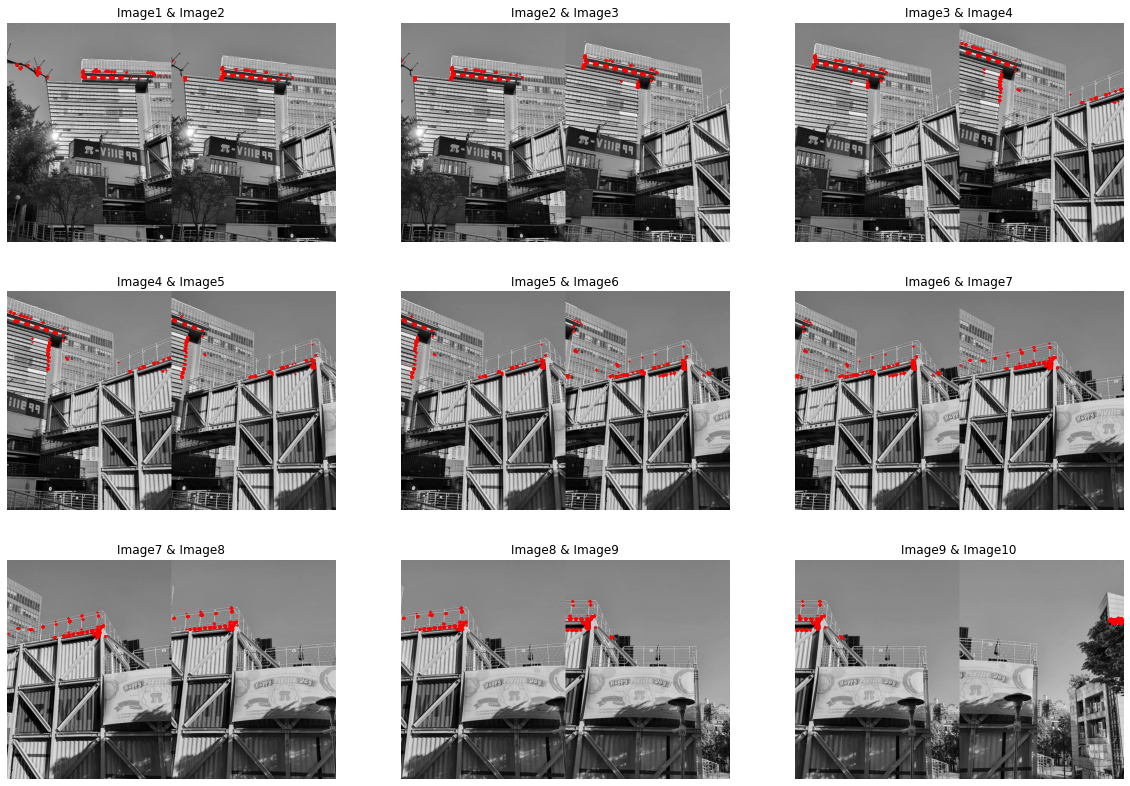

In [139]:
# Plot corners detected
fig, axes = plt.subplots(3, 3, figsize=(20, 14))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        idx = i*3 + j
        
        # base img
        base_img = np.hstack((img_total[idx], img_total[idx+1]))
        col.imshow(base_img, cmap='gray')
        
        # draw matching points
        for x_1, x_2, y_1, y_2 in zip(temp[idx][0][:,1][:500], temp[idx][1][:,1][:500]+600, temp[idx][0][:,0][:500], temp[idx][1][:,0][:500]):
            col.scatter(x=np.ravel([x_1, x_2]), y=np.ravel([y_1, y_2]), c='red', s=1)
            
        col.set_title(f'Image{idx+1} & Image{idx+2}')
        col.axis('off')

# Visualizaing Matches

Feature matches between a set of two images are shown as below;<br>
All the plots are generated using the .pkl files generated above.<br>
We did a lot of experiments to find out best parameters, which is crucial for finding feature matches.<br>

In feature matching and RANSAC algorithm, we found they work best with parameters set as below;
- ratio criterion: 1.2 for cross correlation, 0.9 for euclidean distance
- threshold distance: betwwen 0.3 ~ 0.5
- number of samples in an iteration: 8
- total number of iterations: 50000
- neighbor window size: 7

Our experiments show that using euclidean distance is not as good as using cross-correlation.<br>
Matching features was far more robust when using cross-correlation, which is why we chose it to get the final result.

### Cross Correlation

In [ ]:
match_img1 = np.vstack((fig1_xs, fig1_ys))
match_img2 = np.vstack((fig2_xs, fig2_ys))

In [151]:
# settings
img_set = []
coords_set = []
dist_type = 'corr' # [euc, corr]

# load pkl files
file_dist_id = 'euc' if dist_type=='euc' else 'corr'
for i in range(1, 10):
    pkl_pth = f'./pickle/piville_{file_dist_id}_{i}{i+1}.pkl'
    with open(pkl_pth, 'rb') as rr:
        tmp_dict = pickle.load(rr)

    match_img1, match_img2 = tmp_dict['match_lh'], tmp_dict['match_rh']

    img_set.append((img_total[i-1], img_total[i]))
    coords_set.append([match_img1[0], match_img2[0], match_img1[1], match_img2[1]])

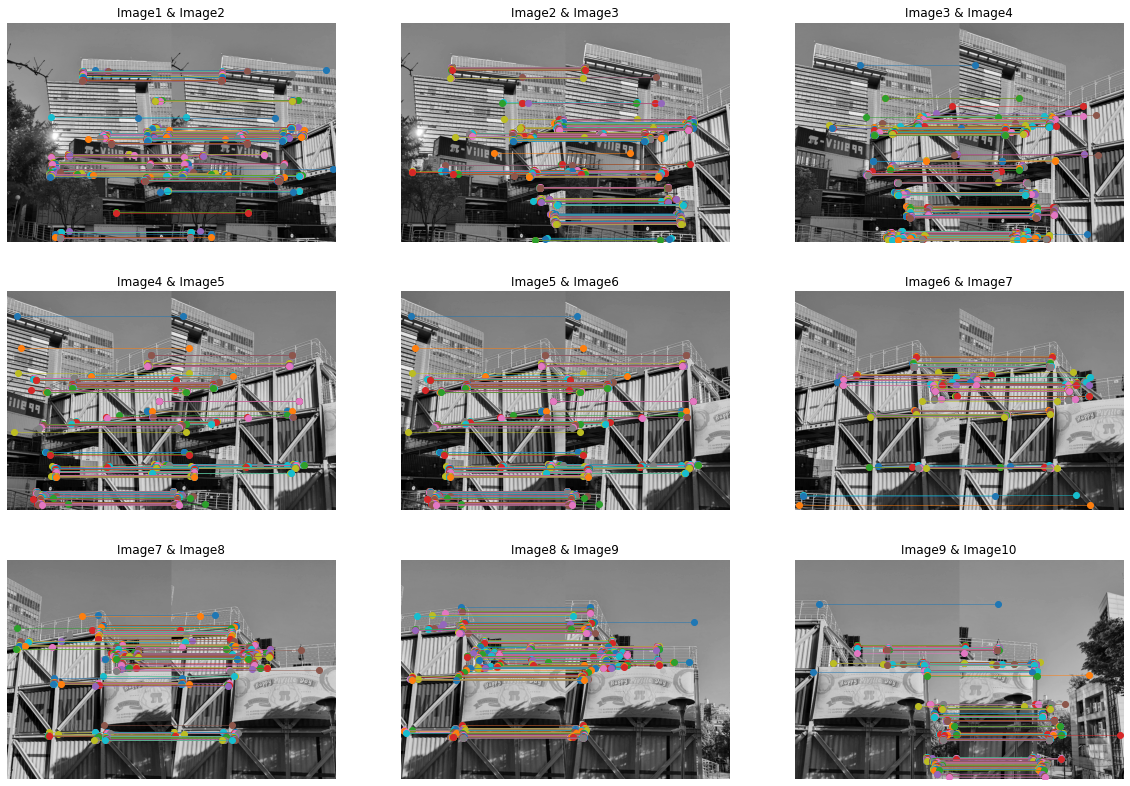

In [152]:
# Plot mathced points between two images
fig, axes = plt.subplots(3, 3, figsize=(20, 14))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        idx = i*3 + j
        
        # base img
        base_img = np.hstack((img_set[idx][0], img_set[idx][1]))
        col.imshow(base_img, cmap='gray')
        
        # draw matching points
        for x_lh, x_rh, y_lh, y_rh in zip(coords_set[idx][0], coords_set[idx][1]+600, coords_set[idx][2], coords_set[idx][3]):
            col.plot([x_lh, x_rh], [y_lh, y_lh], marker = 'o', linewidth=0.5)
        col.set_title(f'Image{idx+1} & Image{idx+2}')
        col.axis('off')

### Eculidean Distance

In [81]:
# settings
img_set = []
coords_set = []
dist_type = 'euc' # [euc, corr]

# load pkl files
file_dist_id = 'euc' if dist_type=='euc' else 'corr'
for i in range(1, 10):
    pkl_pth = f'./pickle/piville_{file_dist_id}_{i}{i+1}.pkl'
    with open(pkl_pth, 'rb') as rr:
        tmp_dict = pickle.load(rr)

    match_img1, match_img2 = tmp_dict['match_lh'], tmp_dict['match_rh']

    img_set.append((img_total[i-1], img_total[i]))
    coords_set.append([match_img1[0], match_img2[0], match_img1[1], match_img2[1]])

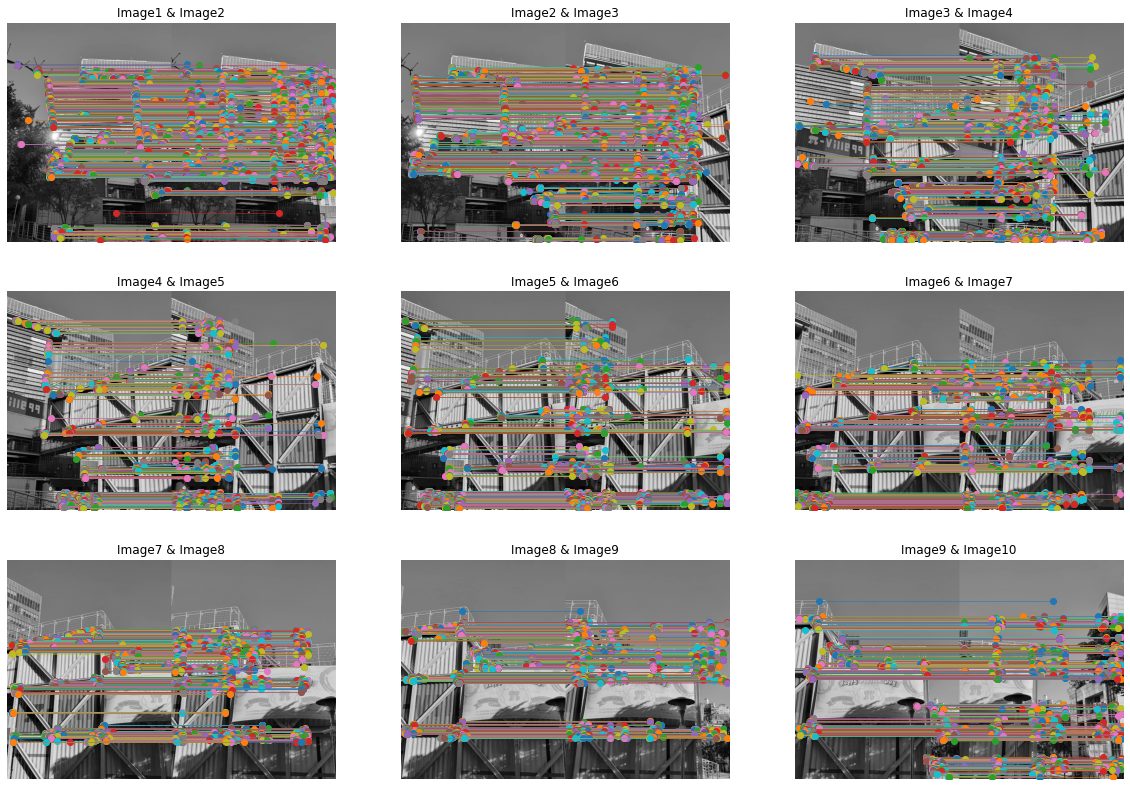

In [82]:
# Plot mathced points between two images
fig, axes = plt.subplots(3, 3, figsize=(20, 14))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        idx = i*3 + j
        
        # base img
        base_img = np.hstack((img_set[idx][0], img_set[idx][1]))
        col.imshow(base_img, cmap='gray')
        
        # draw matching points
        for x_lh, x_rh, y_lh, y_rh in zip(coords_set[idx][0], coords_set[idx][1]+600, coords_set[idx][2], coords_set[idx][3]):
            col.plot([x_lh, x_rh], [y_lh, y_lh], marker = 'o', linewidth=0.5)
        col.set_title(f'Image{idx+1} & Image{idx+2}')
        col.axis('off')

# Stitching Images (Conclusion)

There could be many ways to stitch multiple images together as a one big panorama image, but our own way to do that is as below;<br>
1. We first get all the matching information between each two sequential images.<br>
For example we get the matching points between image1 and image2, followed by image2 and image3, and so on.<br>
2. The base image to start stitching from is the leftest stitched image(in our case image1 & image2).<br>
We then move the matching points between image2 and image3 from image2's side according to the new offset, which is calculated from the homography value between image1 and image2.<br>
3. So far we get a new information: new matching points between image2 and image3. Using this we calculate the homography between (stitched image1 & image2) and (image3).<br>
4. If RANSAC works fine, image3 get well stitched to the former images.<br>
5. We repeat the process above until the last image is stitched<br>

Unfortunately we didn't make it to the last two images. Image1 ~ Image8 gets stitched into a single panorama image quite fine,<br>
but they become so weird when the last two images(9 and 10) gets stitched.<br>
Sad thing is, image8 to image10 themselves gets stitched fine. No matter how much we try, however, it was out of our hand to get them all stitched together.<br>

We assume that this happens because the RANSAC result is quite unstable, for the last 3 images generate relatively small number of matching points than the former ones.<br>
They have some randomness based on sampling, which might be the reason for us not getting the expected result.<br>
We tried hard(taking new pictures, tuning parameters "literally" hundreds of times..) but ended up not quite successful.<br>

We show you both the results of stitching image1 to image8, and image8 to image10.<br>

### (1) Stitch image1 ~ image8

In [123]:
stitch_img_list = img_total # get all loaded images
stitch_dict_list = [load_pkl(f'./pickle/piville_{i}{i+1}.pkl') for i in range(1, 7)] # get pickle file for image 1~8

In [124]:
result = stitch_multiple(stitch_dict_list=stitch_dict_list, stitch_img_list=stitch_img_list)

[1/5]
update at 0th iter: 33
update at 2th iter: 35
update at 3th iter: 83
update at 83th iter: 84
update at 174th iter: 97
update at 272th iter: 104
update at 317th iter: 121
update at 1435th iter: 122
update at 1494th iter: 131
update at 6845th iter: 133
update at 7978th iter: 156
Final number of inliers
: 156
image dsize => (1164, 911)

[2/5]
update at 0th iter: 4
update at 1th iter: 13
update at 2th iter: 28
update at 11th iter: 39
update at 16th iter: 42
update at 22th iter: 51
update at 24th iter: 69
update at 110th iter: 82
update at 222th iter: 92
update at 1583th iter: 95
update at 2314th iter: 103
update at 3448th iter: 120
update at 23758th iter: 125
Final number of inliers
: 125
image dsize => (1386, 1626)

[3/5]
update at 0th iter: 4
update at 1th iter: 30
update at 30th iter: 49
update at 95th iter: 59
update at 674th iter: 67
update at 2309th iter: 69
update at 2801th iter: 70
update at 3041th iter: 74
update at 4543th iter: 79
update at 12330th iter: 85
update at 16605t

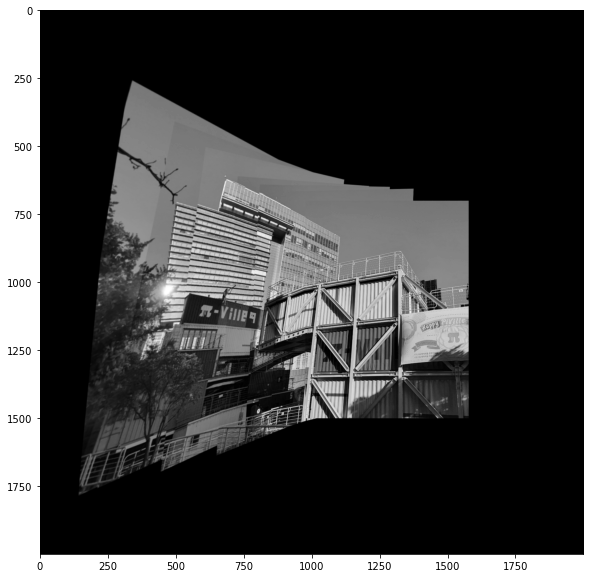

In [126]:
plt.figure(figsize=(10, 10))
plt.imshow(result[:2000, :2000], cmap='gray')

### (2) Stitch image8 ~ image10

In [147]:
img_total[7:]

[array([[126., 127., 126., ..., 125., 126., 126.],
        [128., 128., 127., ..., 127., 126., 126.],
        [128., 128., 126., ..., 127., 126., 126.],
        ...,
        [ 55.,  53.,  48., ...,  95.,  96.,  37.],
        [ 56.,  54.,  51., ...,  67., 108.,  37.],
        [ 52.,  50.,  45., ...,  66., 119.,  35.]]),
 array([[128., 128., 128., ..., 128., 129., 129.],
        [129., 129., 129., ..., 129., 129., 129.],
        [128., 128., 129., ..., 129., 128., 128.],
        ...,
        [ 51.,  49.,  46., ..., 189.,  54., 156.],
        [ 52.,  48.,  47., ..., 192.,  48., 148.],
        [ 52.,  47.,  45., ..., 198.,  49., 152.]]),
 array([[136., 136., 136., ..., 143., 143., 143.],
        [137., 137., 137., ..., 144., 144., 143.],
        [137., 137., 137., ..., 144., 144., 144.],
        ...,
        [ 30.,  29.,  31., ...,   0.,  57.,  81.],
        [ 28.,  28.,  31., ...,   2.,  16.,  76.],
        [ 29.,  29.,  32., ...,   0.,   4.,  65.]])]

In [148]:
stitch_img_list = img_total[7:]
stitch_dict_list = [load_pkl(f'./pickle/piville_corr_{i}{i+1}.pkl') for i in range(8, 10)] # get pickle file for image 8~10

In [149]:
result = stitch_multiple(stitch_dict_list=stitch_dict_list, stitch_img_list=stitch_img_list)

[1/1]
update at 0th iter: 2
update at 2th iter: 29
update at 8th iter: 32
update at 23th iter: 52
update at 95th iter: 63
update at 328th iter: 73
update at 373th iter: 80
update at 2253th iter: 86
update at 2267th iter: 87
update at 2557th iter: 103
update at 27345th iter: 106
update at 28723th iter: 109
Final number of inliers
: 109
image dsize => (1497, 1450)



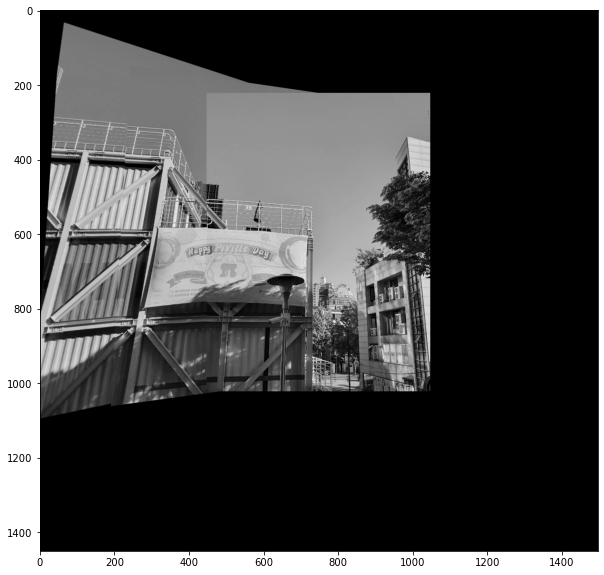

In [150]:
plt.figure(figsize=(10, 10))
plt.imshow(result, cmap='gray')

# Appendix: Stitching Images with OpenCV

In [157]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [158]:
folder_path

'./data'

In [161]:
img_list = sorted(glob(os.path.join(os.getcwd(), 'data/*.jpeg')))

In [162]:
print(img_list)

['/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville01.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville02.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville03.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville04.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville05.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville06.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville07.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville08.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville09.jpeg', '/home/sks/korea_univ/21_1/computer_vision/assignment/assignment_4/data/piville10.jpeg']


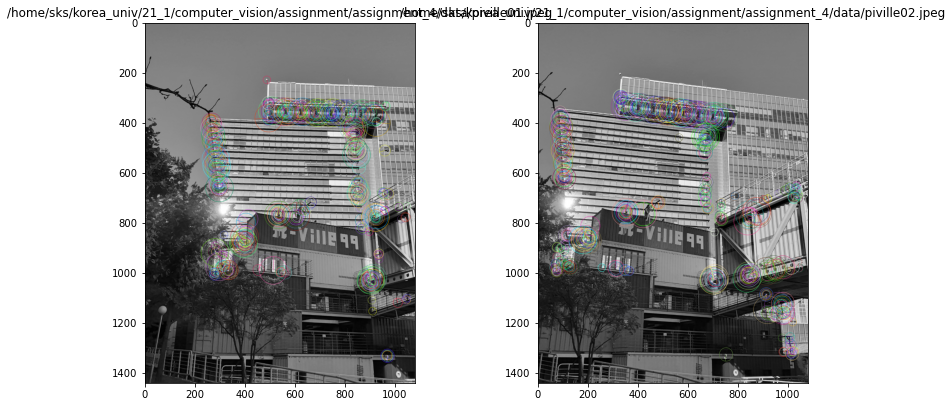

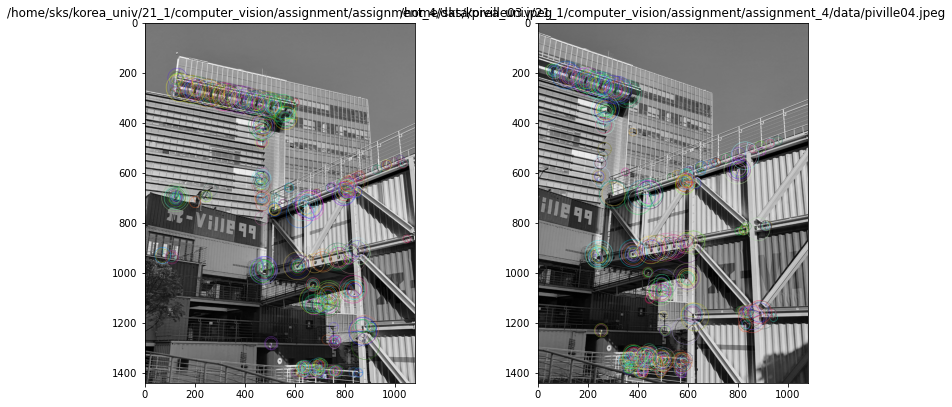

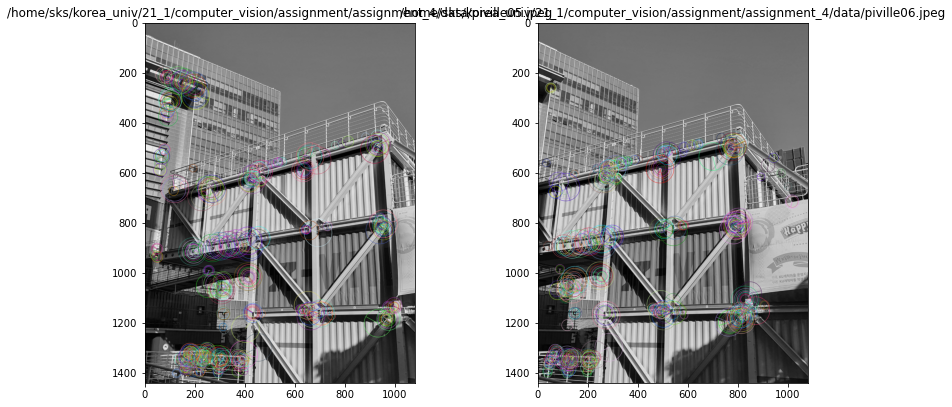

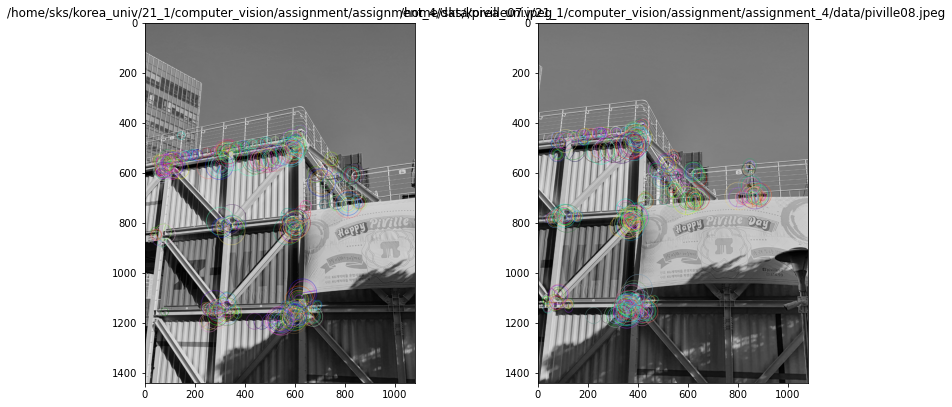

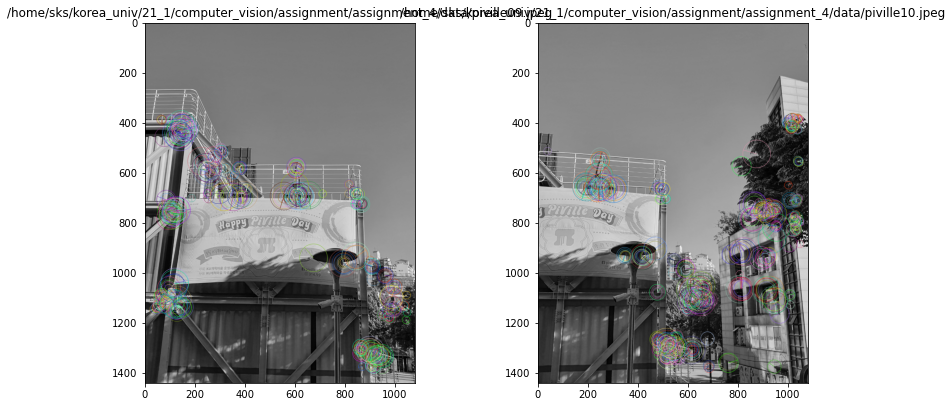

In [163]:
img = [x for x in range(len(img_list))]

# load images
for i in range(len(img_list)):
    img[i] = cv2.imread(os.path.join(folder_path, img_list[i]),cv2.IMREAD_GRAYSCALE)
    img[i] = cv2.cvtColor(img[i], cv2.COLOR_GRAY2BGR)

# detect feature
kp_list = []
desc_list = []

for i in range(0,len(img_list),2):
    # create feature detection object (chosen algorithm: ORB)
    feature = cv2.ORB_create()

    kp1 = feature.detect(img[i])
    kp_list.append(kp1)

    _, desc1 = feature.compute(img[i], kp1)
    desc_list.append(desc1)

    kp2 = feature.detect(img[i+1])
    kp_list.append(kp2)
    _, desc2 = feature.compute(img[i+1], kp2)
    desc_list.append(desc2)

    dst1 = cv2.drawKeypoints(img[i], kp1, None,
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    dst2 = cv2.drawKeypoints(img[i+1], kp2, None,
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    fig, ax = plt.subplots(1,2,figsize=(10,5))

    ax[0].imshow(dst1)
    ax[0].set_title(img_list[i])
    ax[1].imshow(dst2)
    ax[1].set_title(img_list[i+1])

    plt.subplots_adjust(left=0, bottom=0, right=1,top=1)
    
    plt.show()

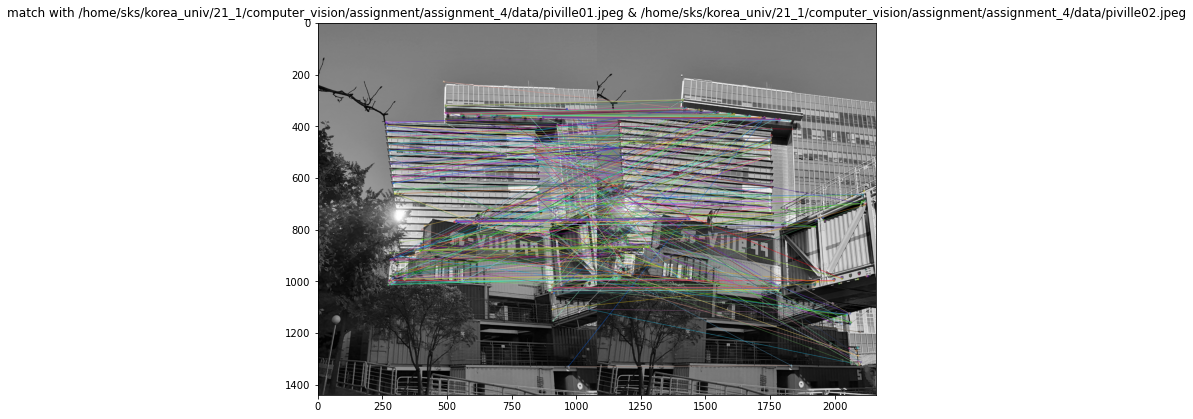

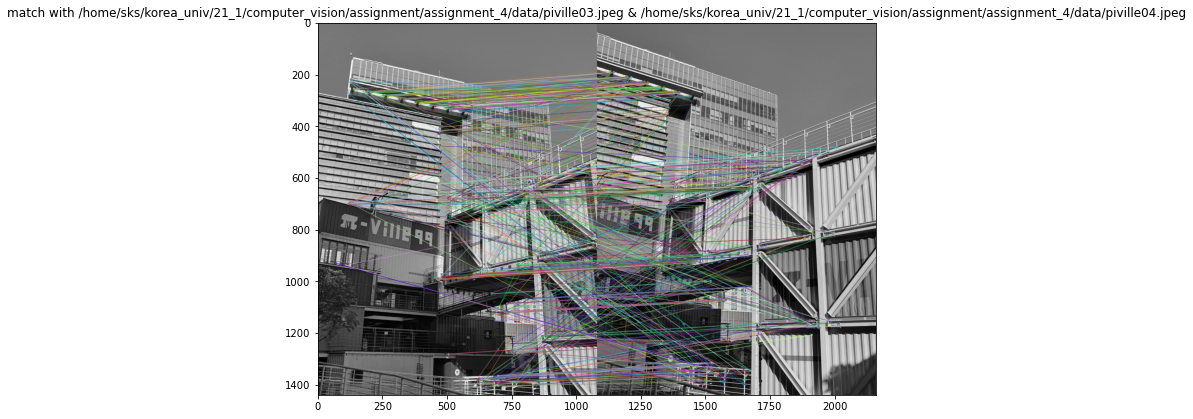

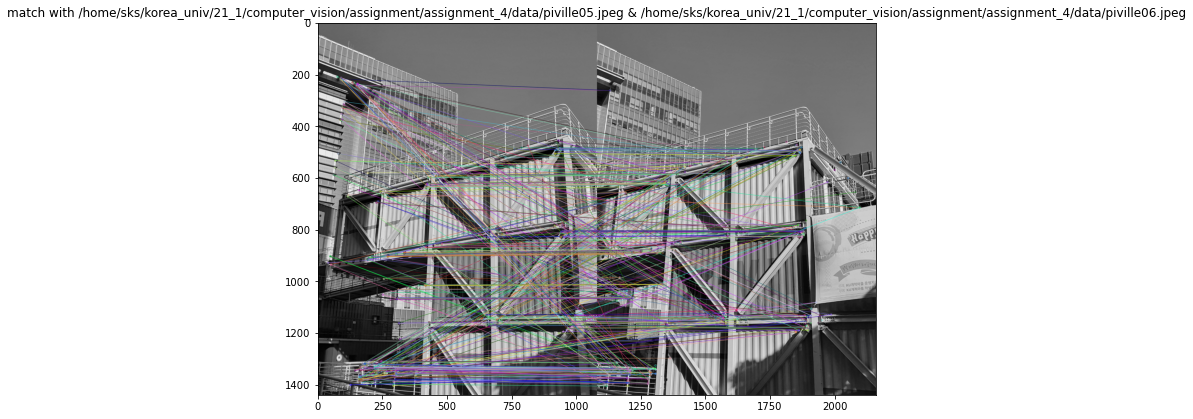

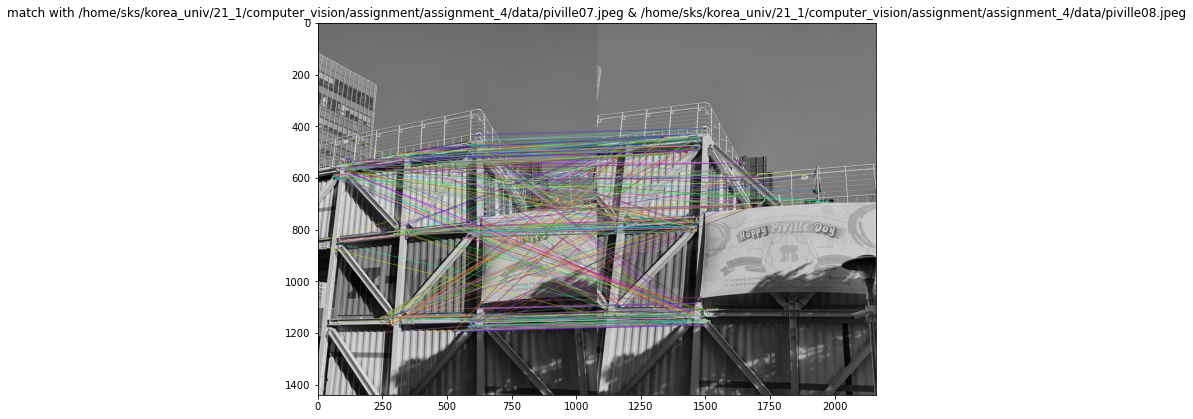

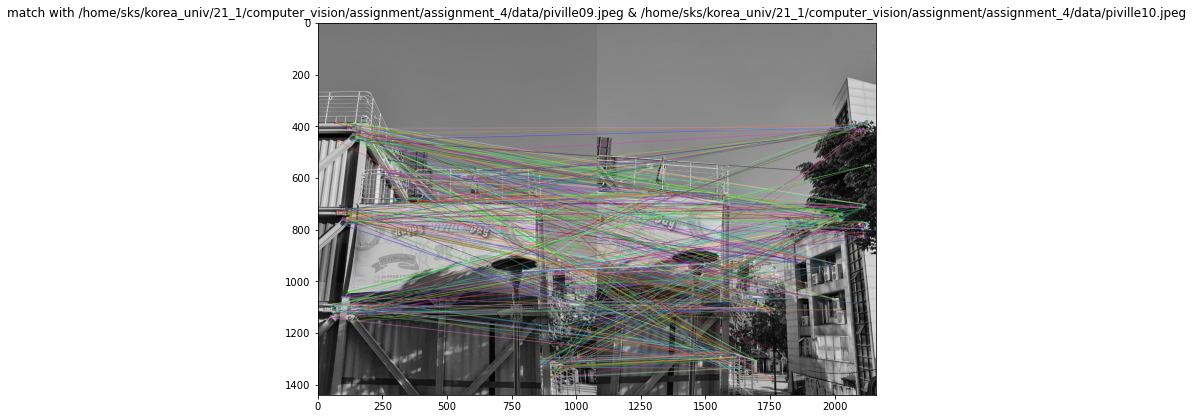

In [164]:
# image matching
for i in range(0,len(img_list),2):
    matcher = cv2.BFMatcher_create()
    matches = matcher.match(desc_list[i], desc_list[i+1])

    dst = cv2.drawMatches(img[i], kp_list[i], img[i+1], kp_list[i+1], matches, None)

    plt.figure(figsize=(10,10))
    plt.imshow(dst)
    plt.title('match with {} & {}'.format(img_list[i], img_list[i+1]))
    plt.show()

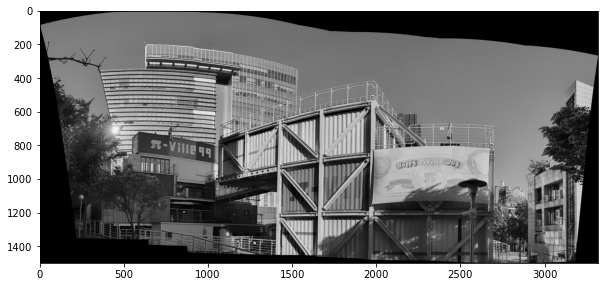

In [165]:
stitcher = cv2.Stitcher_create()
status, dst = stitcher.stitch(img)

plt.figure(figsize=(10,10))
plt.imshow(dst)